In [1]:
# Create folder named experiment#1 in processed data, outputs and analysis

# Get data for flow, tessellations, demographics and geographical boundary of WA

# Split data into training and test - create four files: Flows for train and test, region indices for train and test
# Save these files in processed data folder 
# Create visualization and save to outputs of experiement

# Biased sampling on the training data to create two biased datasets - save in processed data folder for experiment1 

# Run single constrained gravity model on biased training data and original data to create three models 
# Run trained models on unbiased test data and create generated flows in outputs 

# Use generated flows from outputs and test true labels from processed data to create fairness metrics and visualizations
# Save this in outputs - fairness.json and fairness.png (for each model)

In [2]:
import sys
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

experiment_id = '1'

Tessellation crs is epsg:4326
Tessellation crs is epsg:4326


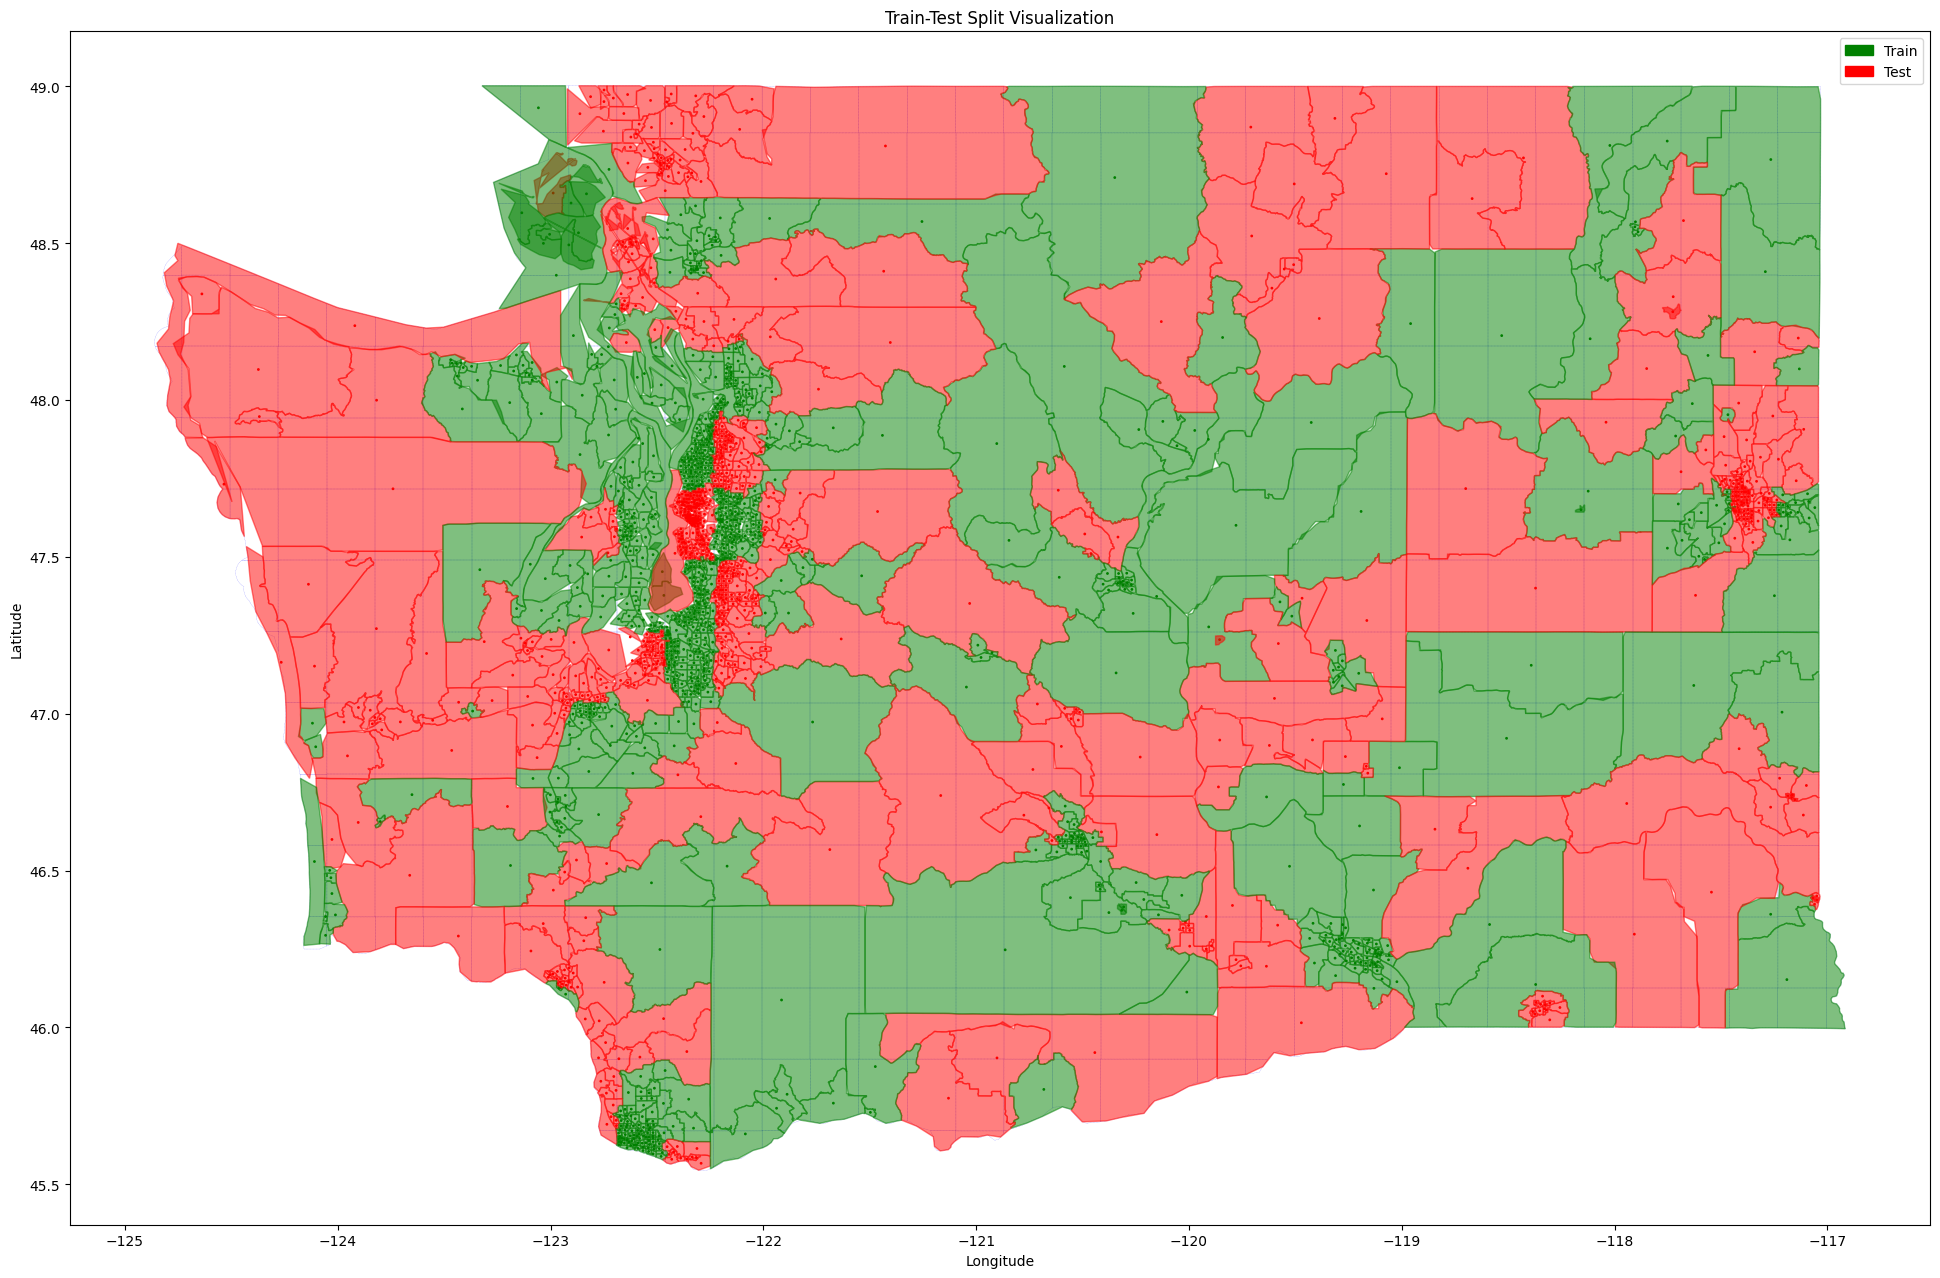

/Users/apoorvasheera/anaconda3/envs/crowdflow/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/apoorvasheera/anaconda3/envs/crowdflow/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed and saved all datasets successfully.
Missing geoids tessellation have been saved to ../processed_data/1/diagnosis_split_missing/missing_geoids_tessellation.csv.


In [2]:
# Split the data into train and test sets

sys.path.append(os.path.abspath('../preprocessing'))
from train_test_processing import *
sys.path.append(os.path.abspath('../preprocessing'))
from train_test_split_vis import *
sys.path.append(os.path.abspath('../utils'))
from crs_conversion import *

washington = load_state_or_county_data('../data/WA/boundary.geojson')
flow_df = pd.read_csv('../data/WA/flow.csv')
features_df = pd.read_csv('../data/WA/features.csv')

# convert_crs_epsg('../data/WA/tessellation_wpop.geojson', '../data/WA/tessellation_wpop_new.geojson', 2927, 4326)
tessellation_df = load_state_or_county_data('../data/WA/tessellation_wpop_new.geojson')

grid = create_grid(washington.unary_union, 25)
train_output, test_output = flow_train_test_split(tessellation_df, features_df, grid, experiment_id = experiment_id)
plot_grid_and_census_tracts(tessellation_df, grid, train_output, test_output, experiment_id = experiment_id)
filter_train_test_data(flow_df, tessellation_df, features_df, train_output, test_output, experiment_id = experiment_id)

In [3]:
# Biased sampling train flow data

sys.path.append(os.path.abspath('../preprocessing'))
from biased_sampling import *

features_df = pd.read_csv('../processed_data/1/train/train_features.csv')
train_flows_df = pd.read_csv('../processed_data/1/train/flows/train_flow.csv')
demographics_df = pd.read_csv('../data/WA/demographics.csv')


calculate_biased_flow(features_df, demographics_df, train_flows_df, demographic_column_name='svi', method=1, order='ascending', sampling=False, experiment_id=experiment_id, bias_factor=0.5)
calculate_biased_flow(features_df, demographics_df, train_flows_df, demographic_column_name='svi', method=1, order='descending', sampling=False, experiment_id=experiment_id, bias_factor=0.5)
calculate_biased_flow(features_df, demographics_df, train_flows_df, demographic_column_name='svi', method=2, order='ascending', sampling=False, experiment_id=experiment_id, bias_factor=0.5)
calculate_biased_flow(features_df, demographics_df, train_flows_df, demographic_column_name='svi', method=2, order='descending', sampling=False, experiment_id=experiment_id, bias_factor=0.5)

/Users/apoorvasheera/Documents/DSSG/Crowd Flow/branches/crowdflow-fairness/preprocessing/biased_sampling.py:32: FutureWarning: Passing 'suffixes' which cause duplicate columns {'geoid_x'} in the result is deprecated and will raise a MergeError in a future version.
  destination_merge = pd.merge(destination_merge, features_df[['geoid', 'total_population']], how='left', left_on='destination', right_on='geoid')


Missing train sampling flow diagnostic saved to ../processed_data/1/train/diagnosis_sampling_missing/missing_flow.csv.
Saved adjusted flows to ../processed_data/1/train/flows/svi/1_ascending_biased_flow.csv.
Missing train sampling flow diagnostic saved to ../processed_data/1/train/diagnosis_sampling_missing/missing_flow.csv.


/Users/apoorvasheera/Documents/DSSG/Crowd Flow/branches/crowdflow-fairness/preprocessing/biased_sampling.py:32: FutureWarning: Passing 'suffixes' which cause duplicate columns {'geoid_x'} in the result is deprecated and will raise a MergeError in a future version.
  destination_merge = pd.merge(destination_merge, features_df[['geoid', 'total_population']], how='left', left_on='destination', right_on='geoid')


Saved adjusted flows to ../processed_data/1/train/flows/svi/1_descending_biased_flow.csv.
Missing train sampling flow diagnostic saved to ../processed_data/1/train/diagnosis_sampling_missing/missing_flow.csv.


/Users/apoorvasheera/Documents/DSSG/Crowd Flow/branches/crowdflow-fairness/preprocessing/biased_sampling.py:32: FutureWarning: Passing 'suffixes' which cause duplicate columns {'geoid_x'} in the result is deprecated and will raise a MergeError in a future version.
  destination_merge = pd.merge(destination_merge, features_df[['geoid', 'total_population']], how='left', left_on='destination', right_on='geoid')


Saved adjusted flows to ../processed_data/1/train/flows/svi/2_ascending_biased_flow.csv.
Missing train sampling flow diagnostic saved to ../processed_data/1/train/diagnosis_sampling_missing/missing_flow.csv.


/Users/apoorvasheera/Documents/DSSG/Crowd Flow/branches/crowdflow-fairness/preprocessing/biased_sampling.py:32: FutureWarning: Passing 'suffixes' which cause duplicate columns {'geoid_x'} in the result is deprecated and will raise a MergeError in a future version.
  destination_merge = pd.merge(destination_merge, features_df[['geoid', 'total_population']], how='left', left_on='destination', right_on='geoid')


Saved adjusted flows to ../processed_data/1/train/flows/svi/2_descending_biased_flow.csv.


In [7]:
# Fit gravity model

sys.path.append(os.path.abspath('../models'))
from gravity import *

tessellation_train = gpd.read_file('../processed_data/1/train/train_tessellation.geojson')
tessellation_test = gpd.read_file('../processed_data/1/test/test_tessellation.geojson')

gravity_0 = grav_Model(tessellation_train, tessellation_test, '../processed_data/1/train/flows/train_flow.csv', '../processed_data/1/test/flows/test_flow.csv', 'gravity_singly_constrained', 'flows')

In [5]:
gravity_1 = grav_Model(tessellation_train, tessellation_test, '../processed_data/1/train/flows/svi/1_ascending_biased_flow.csv', '../processed_data/1/test/flows/test_flow.csv', 'gravity_singly_constrained', 'flows')

Model fitting starts...
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Inte

100%|██████████| 628/628 [00:00<00:00, 1928.51it/s]
/Users/apple/opt/anaconda3/envs/pycharm_crowdflow/lib/python3.9/site-packages/skmob/models/gravity.py:43: RuntimeWarning: divide by zero encountered in power
  return np.power(x, exponent)
/Users/apple/opt/anaconda3/envs/pycharm_crowdflow/lib/python3.9/site-packages/skmob/models/gravity.py:298: RuntimeWarning: invalid value encountered in multiply
  trip_probs_matrix = trip_probs_matrix * relevances_dest ** self.destination_exp * \
/Users/apple/opt/anaconda3/envs/pycharm_crowdflow/lib/python3.9/site-packages/skmob/models/gravity.py:378: RuntimeWarning: invalid value encountered in divide
  trip_probs_matrix = (trip_probs_matrix.T / np.sum(trip_probs_matrix, axis=1)).T


In [8]:
gravity_2 = grav_Model(tessellation_train, tessellation_test, '../processed_data/1/train/flows/svi/1_descending_biased_flow.csv', '../processed_data/1/test/flows/test_flow.csv', 'gravity_singly_constrained', 'flows')

Model fitting starts...
Model fitting completed.


100%|██████████| 628/628 [00:00<00:00, 1605.08it/s]
/Users/apoorvasheera/anaconda3/envs/crowdflow/lib/python3.9/site-packages/skmob/models/gravity.py:43: RuntimeWarning: divide by zero encountered in power
  return np.power(x, exponent)
/Users/apoorvasheera/anaconda3/envs/crowdflow/lib/python3.9/site-packages/skmob/models/gravity.py:298: RuntimeWarning: invalid value encountered in multiply
  trip_probs_matrix = trip_probs_matrix * relevances_dest ** self.destination_exp * \
/Users/apoorvasheera/anaconda3/envs/crowdflow/lib/python3.9/site-packages/skmob/models/gravity.py:378: RuntimeWarning: invalid value encountered in divide
  trip_probs_matrix = (trip_probs_matrix.T / np.sum(trip_probs_matrix, axis=1)).T


In [9]:
gravity_3 = grav_Model(tessellation_train, tessellation_test, '../processed_data/1/train/flows/svi/2_ascending_biased_flow.csv', '../processed_data/1/test/flows/test_flow.csv', 'gravity_singly_constrained', 'flows')

Model fitting starts...
Model fitting completed.


100%|██████████| 628/628 [00:00<00:00, 1545.71it/s]
/Users/apoorvasheera/anaconda3/envs/crowdflow/lib/python3.9/site-packages/skmob/models/gravity.py:43: RuntimeWarning: divide by zero encountered in power
  return np.power(x, exponent)
/Users/apoorvasheera/anaconda3/envs/crowdflow/lib/python3.9/site-packages/skmob/models/gravity.py:298: RuntimeWarning: invalid value encountered in multiply
  trip_probs_matrix = trip_probs_matrix * relevances_dest ** self.destination_exp * \
/Users/apoorvasheera/anaconda3/envs/crowdflow/lib/python3.9/site-packages/skmob/models/gravity.py:378: RuntimeWarning: invalid value encountered in divide
  trip_probs_matrix = (trip_probs_matrix.T / np.sum(trip_probs_matrix, axis=1)).T


In [12]:
gravity_4 = grav_Model(tessellation_train, tessellation_test, '../processed_data/1/train/flows/svi/2_descending_biased_flow.csv', '../processed_data/1/test/flows/test_flow.csv', 'gravity_singly_constrained', 'flows')

Model fitting starts...
Model fitting completed.


100%|██████████| 628/628 [00:00<00:00, 1597.46it/s]
/Users/apoorvasheera/anaconda3/envs/crowdflow/lib/python3.9/site-packages/skmob/models/gravity.py:43: RuntimeWarning: divide by zero encountered in power
  return np.power(x, exponent)
/Users/apoorvasheera/anaconda3/envs/crowdflow/lib/python3.9/site-packages/skmob/models/gravity.py:298: RuntimeWarning: invalid value encountered in multiply
  trip_probs_matrix = trip_probs_matrix * relevances_dest ** self.destination_exp * \
/Users/apoorvasheera/anaconda3/envs/crowdflow/lib/python3.9/site-packages/skmob/models/gravity.py:378: RuntimeWarning: invalid value encountered in divide
  trip_probs_matrix = (trip_probs_matrix.T / np.sum(trip_probs_matrix, axis=1)).T


In [1]:
import sys
import os
sys.path.append(os.path.abspath('../evaluation'))
from eval import FlowEvaluator

flows_path = '../processed_data/1/test/flows/test_flow.csv'
generated_flows_path = '../outputs/1/synthetic_data_gravity_singly_constrained/train_flow.csv' # TODO change accordingly
demographics_path = '../data/WA/demographics.csv'
demographic_column = 'svi'
evaluator_0 = FlowEvaluator(flows_path, generated_flows_path, demographics_path)
outcome_0 = evaluator_0.evaluate_fairness(accuracy_metric='CPC', variance_metric='kl_divergence', demographic_column=demographic_column)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Directory already exists: ../outputs/1/results/heatmaps
Heatmap saved to ../outputs/1/results/heatmaps/train_flow_heatmap.png
Fairness Metric (kl_divergence of CPC): 0.01337703138804307
Overall CPC: 0.2863387810579544


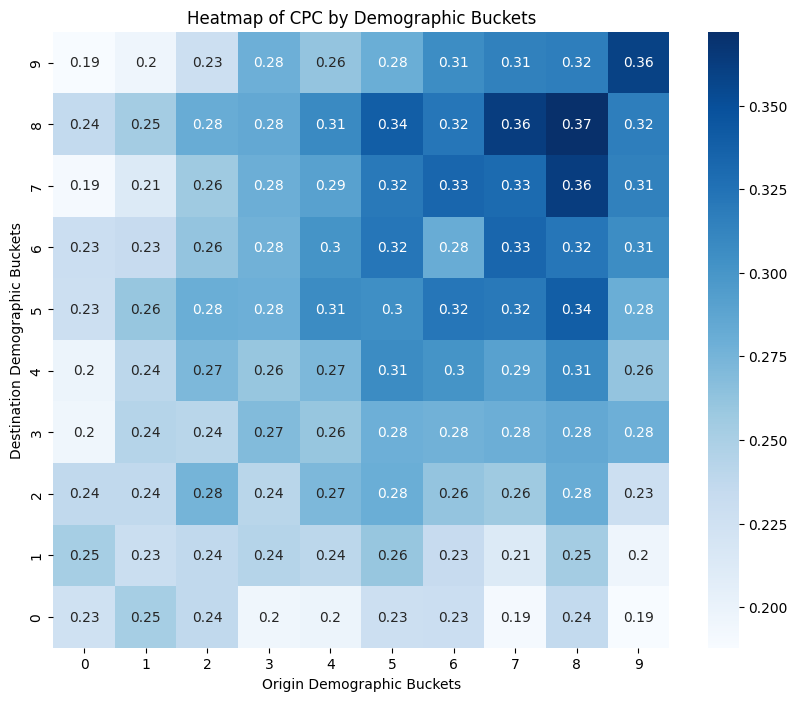

Fairness Metric (kl_divergence of CPC): 0.013421956054325196
Overall CPC: 0.28055797524645765


In [1]:
flows_path = '../processed_data/1/test/flows/test_flow.csv'
generated_flows_path = '../outputs/1/synthetic_data_gravity_singly_constrained/svi/1_ascending_biased_flow.csv' # TODO change accordingly
demographics_path = '../data/WA/demographics.csv'
demographic_column = 'svi'
evaluator_1 = FlowEvaluator(flows_path, generated_flows_path, demographics_path)
outcome_1 = evaluator_1.evaluate_fairness(accuracy_metric='CPC', variance_metric='kl_divergence', demographic_column=demographic_column)

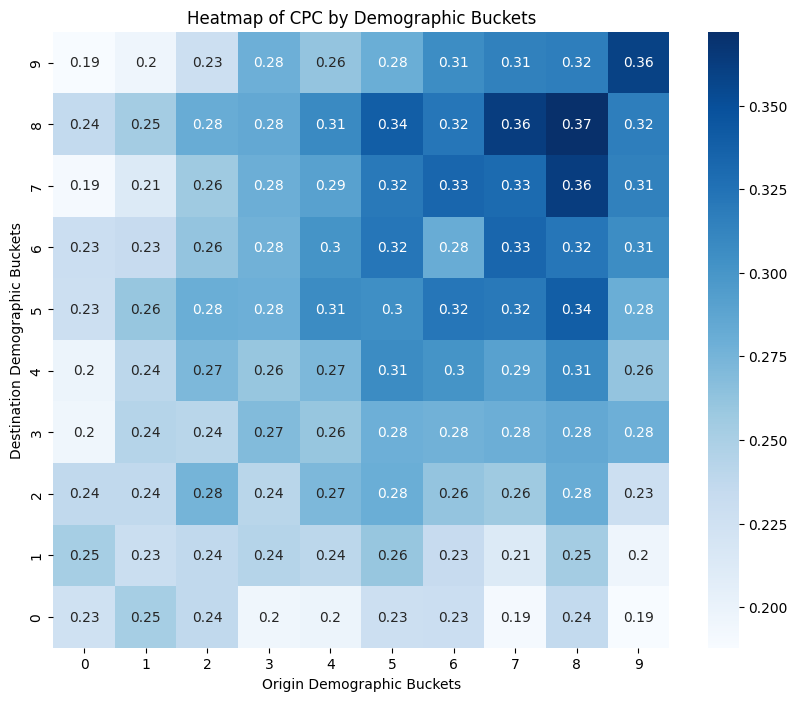

Fairness Metric (kl_divergence of CPC): 0.013421956054325208
Overall CPC: 0.2805579752464571


In [10]:
flows_path = '../processed_data/1/test/flows/test_flow.csv'
generated_flows_path = '../outputs/1/synthetic_data_gravity_singly_constrained/svi/1_descending_biased_flow.csv' # TODO change accordingly
demographics_path = '../data/WA/demographics.csv'
demographic_column = 'svi'
evaluator_2 = FlowEvaluator(flows_path, generated_flows_path, demographics_path)
outcome_2 = evaluator_2.evaluate_fairness(accuracy_metric='CPC', variance_metric='kl_divergence', demographic_column=demographic_column)

In [38]:
flows_path = '../processed_data/1/test/flows/test_flow.csv'
generated_flows_path = '../outputs/1/synthetic_data_gravity_singly_constrained/svi/2_ascending_biased_flow.csv' # TODO change accordingly
demographics_path = '../data/WA/demographics.csv'
demographic_column = 'svi'
evaluator_3 = FlowEvaluator(flows_path, generated_flows_path, demographics_path)
outcome_3 = evaluator_3.evaluate_fairness(accuracy_metric='CPC', variance_metric='kl_divergence', demographic_column=demographic_column)

Directory already exists: ../outputs/1/results/heatmaps
Heatmap saved to ../outputs/1/results/heatmaps/2_ascending_biased_flow_heatmap.png
Fairness Metric (kl_divergence of CPC): 0.013421956054325208
Overall CPC: 0.2805579752464571


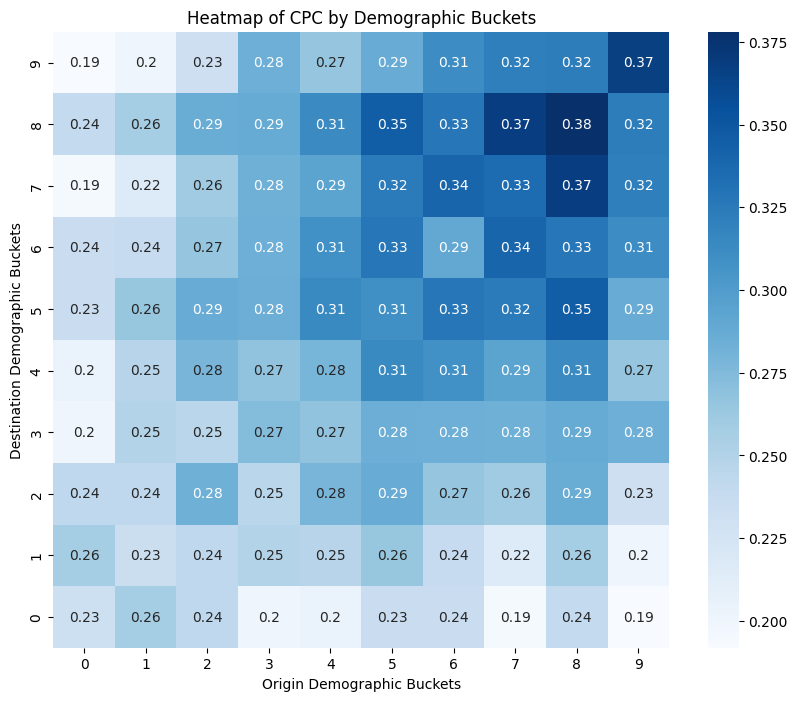

Fairness Metric (kl_divergence of CPC): 0.01311374832710344
Overall CPC: 0.2861760388498589


In [4]:
flows_path = '../processed_data/1/test/flows/test_flow.csv'
generated_flows_path = '../outputs/1/synthetic_data_gravity_singly_constrained/svi/2_descending_biased_flow.csv' # TODO change accordingly
demographics_path = '../data/WA/demographics.csv'
demographic_column = 'svi'
evaluator_4 = FlowEvaluator(flows_path, generated_flows_path, demographics_path)
outcome_4 = evaluator_4.evaluate_fairness(accuracy_metric='CPC', variance_metric='kl_divergence', demographic_column=demographic_column)

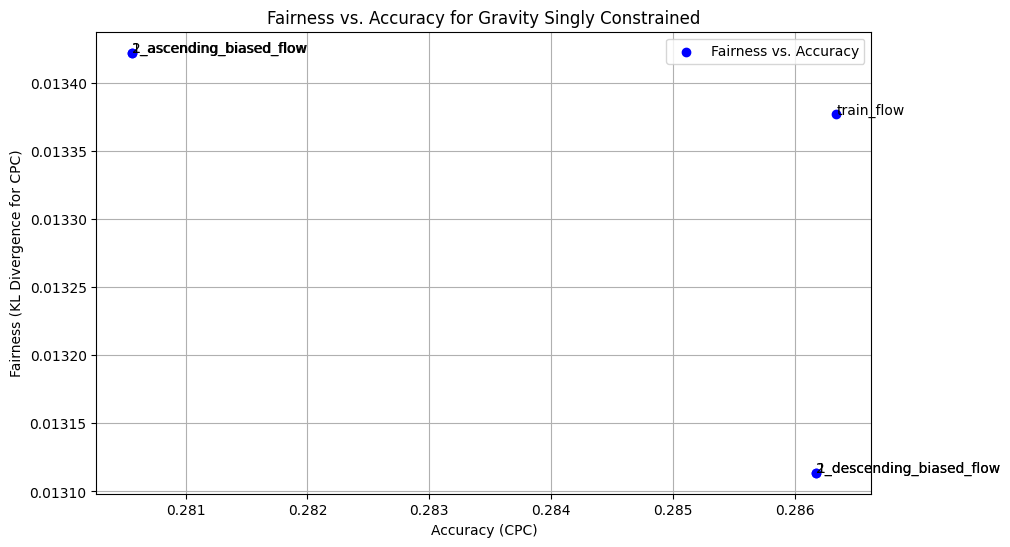

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

results = pd.read_csv("../outputs/1/results/results.csv")
fairness = results['fairness']
accuracy = results['accuracy']

plt.figure(figsize=(10, 6))
plt.scatter(accuracy, fairness, color='blue', label='Fairness vs. Accuracy')
plt.xlabel('Accuracy (Mean CPC)')
plt.ylabel('Fairness (KL Divergence for CPC)')
plt.title('Fairness vs. Accuracy for Gravity Singly Constrained')
for i, txt in enumerate(results['data']):
    plt.annotate(txt, (accuracy[i], fairness[i]))
plt.legend()
plt.grid(True)
plt.show()

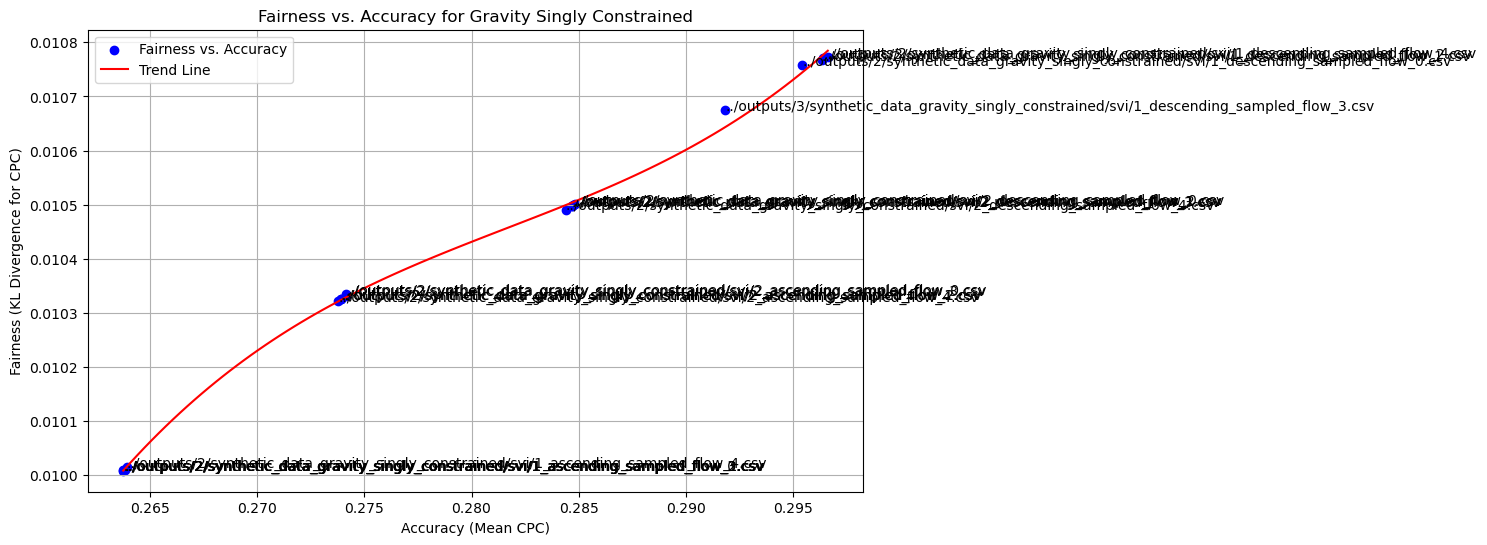

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
results = pd.read_csv("../outputs/2/results/results.csv")
fairness = results['fairness']
accuracy = results['accuracy']

# Create the plot
plt.figure(figsize=(10, 6))

# Scatter plot
plt.scatter(accuracy, fairness, color='blue', label='Fairness vs. Accuracy')

# Fitting a polynomial curve
z = np.polyfit(accuracy, fairness, deg=3)  # Adjust degree as needed for the best fit
p = np.poly1d(z)
xp = np.linspace(min(accuracy), max(accuracy), 100)  # Generates 100 linearly spaced points
plt.plot(xp, p(xp), 'r-', label='Trend Line')  # Red line for the trend

# Labels and title
plt.xlabel('Accuracy (Mean CPC)')
plt.ylabel('Fairness (KL Divergence for CPC)')
plt.title('Fairness vs. Accuracy for Gravity Singly Constrained')

# Annotate each point
for i, txt in enumerate(results['filename']):
    plt.annotate(txt, (accuracy[i], fairness[i]))

# Legend and grid
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


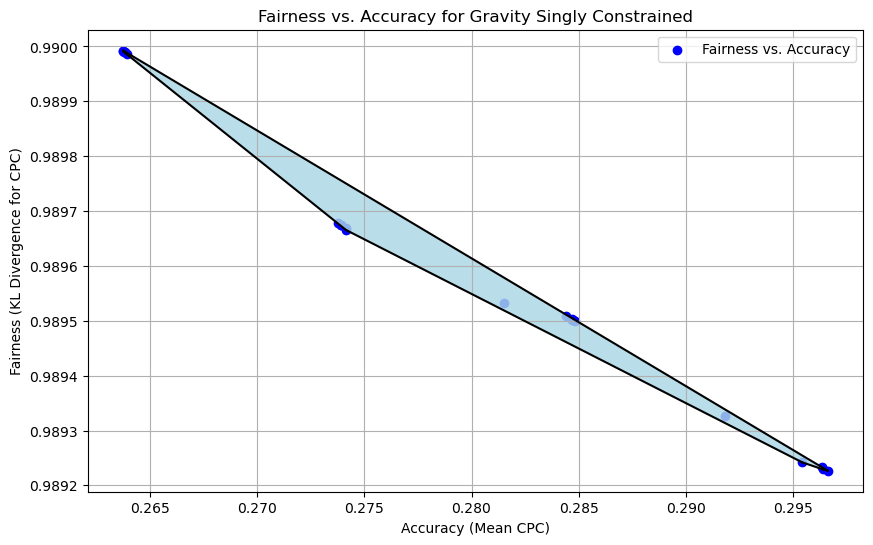

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull

# Load the data
results = pd.read_csv("../outputs/2/results/results.csv")
fairness = results['fairness']
accuracy = results['accuracy']

# Create the plot
plt.figure(figsize=(10, 6))

# Scatter plot
plt.scatter(accuracy, 1-fairness, color='blue', label='Fairness vs. Accuracy')

# Calculate the convex hull
points = np.column_stack((accuracy, 1-fairness))
hull = ConvexHull(points)
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')  # Black line for the hull edges

# Fill the convex hull with a color
for simplex in hull.simplices:
    plt.fill(points[hull.vertices, 0], points[hull.vertices, 1], 'lightblue', alpha=0.2)  # Light blue fill

# Labels and title
plt.xlabel('Accuracy (Mean CPC)')
plt.ylabel('Fairness (KL Divergence for CPC)')
plt.title('Fairness vs. Accuracy for Gravity Singly Constrained')

# Annotate each point
# for i, txt in enumerate(results['filename']):
#     plt.annotate(txt, (accuracy[i], fairness[i]))

plt.ylim(plt.ylim())

# Legend and grid
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

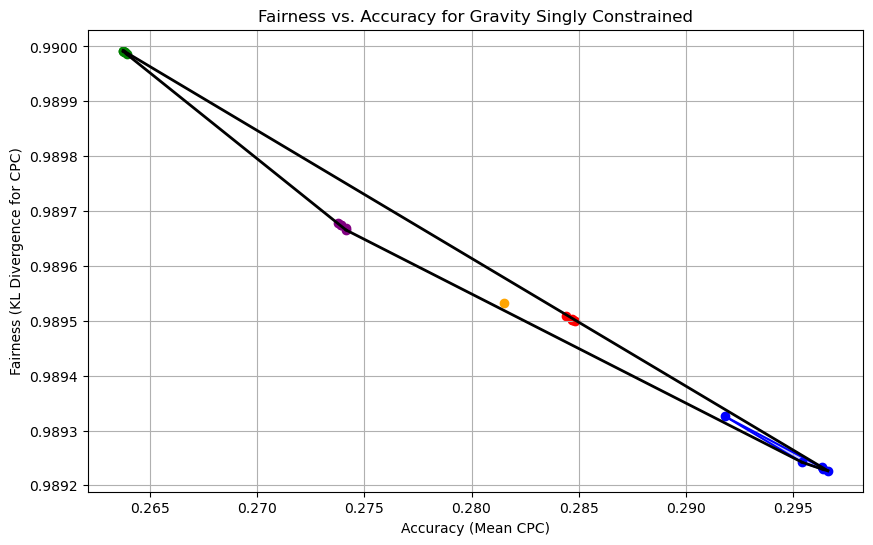

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull

# Load the data
results = pd.read_csv("../outputs/2/results/results.csv")
fairness = results['fairness']
accuracy = results['accuracy']

# Categorize the files based on the filename
def categorize_file(filename):
    if '1_descending' in filename:
        return '1_descending'
    elif '1_ascending' in filename:
        return '1_ascending'
    elif '2_descending' in filename:
        return '2_descending'
    elif '2_ascending' in filename:
        return '2_ascending'
    elif 'train' in filename:
        return 'train'
    else:
        return 'other'

results['category'] = results['filename'].apply(categorize_file)

# Define colors for each category
colors = {
    '1_descending': 'blue',
    '1_ascending': 'green',
    '2_descending': 'red',
    '2_ascending': 'purple',
    'train': 'orange'
}

# Create the plot
plt.figure(figsize=(10, 6))

# Scatter plot for each category
for category in results['category'].unique():
    subset = results[results['category'] == category]
    plt.scatter(subset['accuracy'], 1-subset['fairness'], color=colors[category], label=category)

# Calculate the convex hull for each category and plot it
for category in results['category'].unique():
    subset = results[results['category'] == category]
    if len(subset) > 2:  # Convex hull requires at least 3 points
        points = np.column_stack((subset['accuracy'], 1-subset['fairness']))
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], color=colors[category])
        plt.fill(points[hull.vertices, 0], points[hull.vertices, 1], colors[category], alpha=0.2)

# Calculate the overall convex hull and plot it in black
all_points = np.column_stack((accuracy, 1-fairness))
overall_hull = ConvexHull(all_points)
for simplex in overall_hull.simplices:
    plt.plot(all_points[simplex, 0], all_points[simplex, 1], 'k-', linewidth=2)  # Black line for the overall hull

# Labels and title
plt.xlabel('Accuracy (Mean CPC)')
plt.ylabel('Fairness (KL Divergence for CPC)')
plt.title('Fairness vs. Accuracy for Gravity Singly Constrained')

plt.ylim(plt.ylim())

# Legend and grid
# plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In [10]:
flows_path = '../processed_data/2/test/flows/test_flow.csv'
# generated_flows_path = '../outputs/2/synthetic_data_gravity_singly_constrained/svi/2_descending_biased_flow.csv'
demographics_path = '../data/WA/demographics.csv'
demographic_column = 'svi'
random_base_path = '../outputs/2/synthetic_data_random'
filenames = os.listdir(random_base_path)

for filename in filenames:
    filepath = os.path.join(random_base_path, filename)
    evaluator = FlowEvaluator(flows_path, filepath, demographics_path)
    fairness, performance = evaluator.evaluate_fairness(accuracy_metric='CPC', variance_metric='kl_divergence', demographic_column=demographic_column)
    
    
    data_to_write = {
                            'filename': filename,
                            'model': 'random',
                            'demographic': demographic_column,
                            'fairness': fairness,
                            'accuracy': performance
                        }
    # Convert the data to a CSV row format
    csv_line = f"{data_to_write['filename']},{data_to_write['model']},{data_to_write['demographic']},{data_to_write['fairness']},{data_to_write['accuracy']}\n"

    # Save to CSV, create file if it does not exist
    result_file_path = "/Users/apple/Documents/GitHub/DSSG/crowdflow-fairness/outputs/2/synthetic_data_random/results_random.csv"
    with open(result_file_path, 'a') as f:
        f.writelines(csv_line)
        print("successfully written to file", result_file_path)

Directory already exists: ../outputs/2/results/heatmaps
Heatmap saved to ../outputs/2/results/heatmaps/synthetic_data_random_13_heatmap.png
Fairness Metric (kl_divergence of CPC): 0.01818367145428533
Overall CPC: 0.0234039669222739
successfully written to file /Users/apple/Documents/GitHub/DSSG/crowdflow-fairness/outputs/2/synthetic_data_random/results_random.csv
Directory already exists: ../outputs/2/results/heatmaps
Heatmap saved to ../outputs/2/results/heatmaps/synthetic_data_random_2_heatmap.png
Fairness Metric (kl_divergence of CPC): 0.018469247187012306
Overall CPC: 0.023460531659372803
successfully written to file /Users/apple/Documents/GitHub/DSSG/crowdflow-fairness/outputs/2/synthetic_data_random/results_random.csv
Directory already exists: ../outputs/2/results/heatmaps
Heatmap saved to ../outputs/2/results/heatmaps/synthetic_data_random_3_heatmap.png
Fairness Metric (kl_divergence of CPC): 0.019183360438290498
Overall CPC: 0.023446406813416882
successfully written to file /Us

Traceback (most recent call last):
  File "/Users/apple/opt/anaconda3/envs/pycharm_crowdflow/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3802, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 165, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 5745, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 5753, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'origin'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/apple/opt/anaconda3/envs/pycharm_crowdflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/b_/vnl787011ld4lxvyz9882wp40000gn/T/ipyke

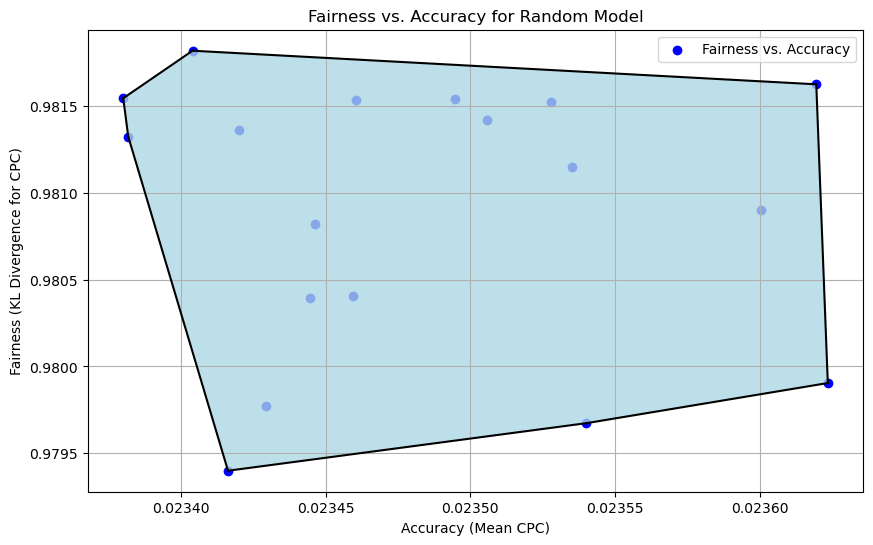

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull

# Load the data
results = pd.read_csv("../outputs/2/synthetic_data_random/results_random.csv")
fairness = results['fairness']
accuracy = results['accuracy']

# Create the plot
plt.figure(figsize=(10, 6))

# Scatter plot
plt.scatter(accuracy, 1-fairness, color='blue', label='Fairness vs. Accuracy')

# Calculate the convex hull
points = np.column_stack((accuracy, 1-fairness))
hull = ConvexHull(points)
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')  # Black line for the hull edges

# Fill the convex hull with a color
for simplex in hull.simplices:
    plt.fill(points[hull.vertices, 0], points[hull.vertices, 1], 'lightblue', alpha=0.2)  # Light blue fill

# Labels and title
plt.xlabel('Accuracy (Mean CPC)')
plt.ylabel('Fairness (KL Divergence for CPC)')
plt.title('Fairness vs. Accuracy for Random Model')

# Annotate each point
# for i, txt in enumerate(results['filename']):
#     plt.annotate(txt, (accuracy[i], fairness[i]))

plt.ylim(plt.ylim())

# Legend and grid
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In [20]:
flows_path = '../processed_data/1/test/flows/test_flow.csv'
generated_flows_path = '../processed_data/1/test/flows/test_flow.csv'
demographics_path = '../data/WA/demographics.csv'
demographic_column = 'svi'
evaluator_test = FlowEvaluator(flows_path, generated_flows_path, demographics_path)
outcome_test = evaluator_test.evaluate_fairness(accuracy_metric='CPC', variance_metric='kl_divergence', demographic_column=demographic_column)

Directory created: ../processed_data/1/results/heatmaps
Heatmap saved to ../processed_data/1/results/heatmaps/test_flow_heatmap.png
Fairness Metric (kl_divergence of CPC): 0.0
Overall CPC: 1.0
